In [0]:
# !pip install pandas

!pip install -U -q PyDrive

     |████████████████████████████████| 993kB 4.9MB/s 


In [0]:
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plot
import sklearn.utils

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

import warnings
warnings.filterwarnings('ignore')

In [0]:
def ReadFileFromGDrive(sharable_link, file_name, read_local, sheet_index = 0):
  
  if read_local:
    print('Read Sheet index ' , sheet_index)
    return pd.read_excel(file_name, sheet_name  = sheet_index)
  
  # Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  link = sharable_link # The shareable link

  fluff, id = link.split('=')
  print (id) # Verify that you have everything after '='

  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(file_name)  
  return pd.read_excel(file_name, sheetname=1)
# --------------------------
def ReadExcel(file_name):
  print('read')
  xlsx = pd.ExcelFile(file_name)
  sheets = []
  print(xlsx.sheet_names)
  for sheet in xlsx.sheet_names:
    sheets.append(xlsx.parse(sheet))
    all_sheets = pd.concat(sheets)
  return all_sheets

In [0]:
students_tarke_tahsil = ReadFileFromGDrive(sharable_link = 'https://drive.google.com/open?id'
                                    ,file_name = 'TarkeTahsil_980401.xlsx' , read_local= True,sheet_index = 0)

students_tarke_tahsil.shape

Read Sheet index  0


(47634, 31)

In [0]:
students_gheyre_tarke_tahsil = ReadFileFromGDrive(sharable_link = 'https://drive.google.com/open?id='
                                    ,file_name = 'TarkeTahsil_980401.xlsx' , read_local= True,sheet_index = 1)

students_gheyre_tarke_tahsil.shape

Read Sheet index  1


(27669, 31)

In [0]:
students_gheyre_tarke_tahsil.insert(28, 'IsStudying', 1)
students_gheyre_tarke_tahsil.head(3)

,Sex,Shift,RegionCode,SchoolType,SchoolCode,Nationality,Religion,MarriageState,FamilyState,BodyState,FatherJob,FatherMadrak,HouseState,JaheshiRahnamaee,LeftHand,StudentType,MotherJob,StudentState,SoldierState,OstanCode,NumberOfChilds,NoChild,MotherMadrak,HistoryRegionCode,Average,StageType,grade,AverageLabel,IsStudying,OstanName,Name,HistoryRegionName
0,1,1,1101,1,10120813,1,1,0,0,0,1,6,0,0,0,1,4,2,0,11,5,6,5,1101,11.195312,5,1,4,1,شهر تهران,پيام شهيد,تهران ناحيه ١
1,1,1,1101,1,10120813,1,1,0,0,0,1,7,0,0,0,1,4,2,0,11,2,2,6,1101,8.662879,5,1,4,1,شهر تهران,پيام شهيد,تهران ناحيه ١
2,1,1,1101,1,10120813,1,1,0,0,0,1,9,2,0,0,1,4,2,0,11,2,2,6,1101,12.678030,5,1,4,1,شهر تهران,پيام شهيد,تهران ناحيه ١


In [0]:
students_gheyre_tarke_tahsil.iloc[:,27].head(3)

0    4
1    4
2    4
Name: AverageLabel, dtype: int64

In [0]:
students_tarke_tahsil.insert(28, 'IsStudying', 0)
students_tarke_tahsil.head(3)

,Sex,Shift,RegionCode,SchoolType,SchoolCode,Nationality,Religion,MarriageState,FamilyState,BodyState,FatherJob,FatherMadrak,HouseState,JaheshiRahnamaee,LeftHand,StudentType,MotherJob,StudentState,SoldierState,OstanCode,NumberOfChilds,NoChild,MotherMadrak,HistoryRegionCode,Average,StageType,grade,AverageLabel,IsStudying,OstanName,Name,HistoryRegionName
0,1,1,1101,1,12873808,1,1,0,0,0,13,1,0,0,0,1,4,4,0,11,0,5,1,1101,1.795455,5,3,4,0,شهر تهران,لواساني دانا**,تهران ناحيه ١
1,1,1,1101,4,10189205,1,1,0,0,0,6,5,0,0,0,1,4,4,0,11,1,2,5,1101,13.448529,5,2,3,0,شهر تهران,حکيم نظامي,تهران ناحيه ١
2,1,1,1101,4,12915607,1,1,0,0,0,6,6,0,0,0,1,4,4,0,11,1,2,6,1101,19.174242,5,1,1,0,شهر تهران,جام جم,تهران ناحيه ١


In [0]:
all_students = sklearn.utils.shuffle(pd.concat([students_tarke_tahsil, students_gheyre_tarke_tahsil], ignore_index=True))

print(all_students.shape)

all_students = all_students.drop('StudentState', axis = 1)

all_students.head(3)

(75303, 32)


,Sex,Shift,RegionCode,SchoolType,SchoolCode,Nationality,Religion,MarriageState,FamilyState,BodyState,FatherJob,FatherMadrak,HouseState,JaheshiRahnamaee,LeftHand,StudentType,MotherJob,SoldierState,OstanCode,NumberOfChilds,NoChild,MotherMadrak,HistoryRegionCode,Average,StageType,grade,AverageLabel,IsStudying,OstanName,Name,HistoryRegionName
57982,1,1,3808,8,70312906,1,1,0,0,0,13,4,0,0,0,1,4,0,38,2,4,3,3808,13.030303,5,1,3,1,کرمان,علامه طباطباي,راور
65854,2,1,1703,1,35348109,1,1,0,0,0,6,5,0,0,0,1,4,0,17,1,4,5,1703,15.159091,5,1,3,1,اصفهان,شيخ فضل اله نوري,اصفهان - ناحيه ٣
2852,1,1,1662,1,53455504,1,1,0,0,0,13,4,0,0,0,1,4,0,16,3,8,4,1662,16.643939,5,1,3,0,خراسان رضوی,شهيد حسين انداده,جوين


In [0]:
hm_input = all_students.iloc[:,0:28]
# hm_input  = Normalize_Column(hm_input, ['Sex','Shift','RegionCode','SchoolType','SchoolCode','Nationality','Religion','MarriageState','FamilyState',
#                                         'BodyState','FatherJob','FatherMadrak','HouseState','LeftHand','StudentType','MotherJob','StudentState','SoldierState',
#                                         'OstanCode','NumberOfChilds','NoChild','MotherMadrak','HistoryRegionCode'])
# -----------------------------------------------
print(hm_input.shape)
hm_input.head(3)

(75303, 28)


,Sex,Shift,RegionCode,SchoolType,SchoolCode,Nationality,Religion,MarriageState,FamilyState,BodyState,FatherJob,FatherMadrak,HouseState,JaheshiRahnamaee,LeftHand,StudentType,MotherJob,SoldierState,OstanCode,NumberOfChilds,NoChild,MotherMadrak,HistoryRegionCode,Average,StageType,grade,AverageLabel,IsStudying
57982,1,1,3808,8,70312906,1,1,0,0,0,13,4,0,0,0,1,4,0,38,2,4,3,3808,13.030303,5,1,3,1
65854,2,1,1703,1,35348109,1,1,0,0,0,6,5,0,0,0,1,4,0,17,1,4,5,1703,15.159091,5,1,3,1
2852,1,1,1662,1,53455504,1,1,0,0,0,13,4,0,0,0,1,4,0,16,3,8,4,1662,16.643939,5,1,3,0


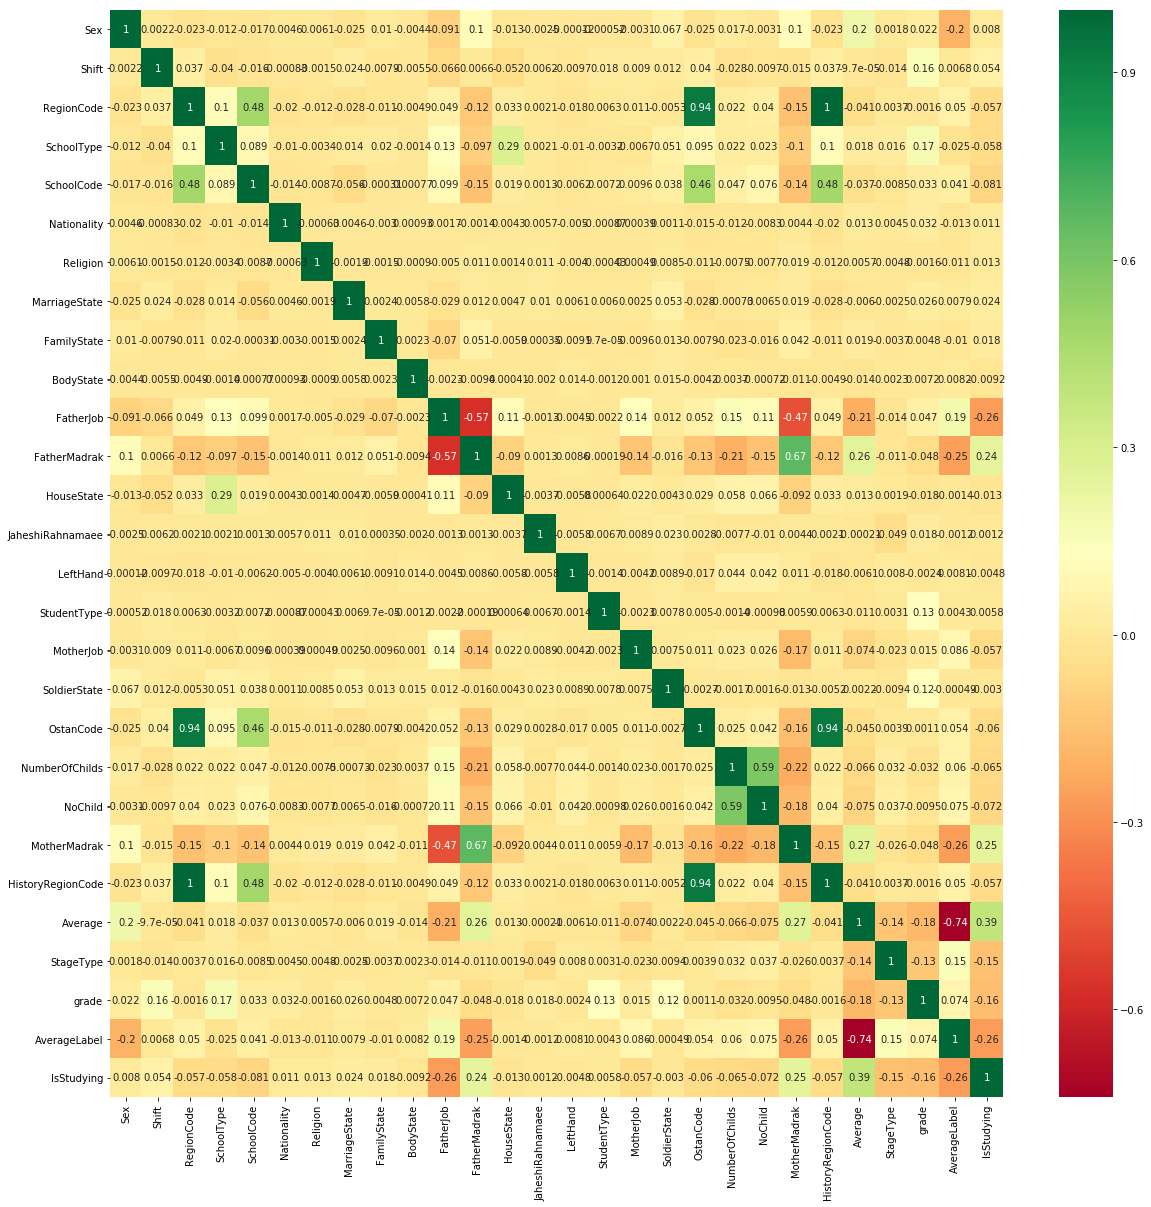

Highly correlated features to IsStudying:


IsStudying      1.000000
Average         0.385911
AverageLabel    0.263784
FatherJob       0.261643
MotherMadrak    0.251521
FatherMadrak    0.239796
grade           0.159088
StageType       0.154575
Name: IsStudying, dtype: float64

In [0]:
# Create HeatMap
X = hm_input.iloc[:,0:28]  #independent columns
y = hm_input['IsStudying']   #target column

#get correlations of each features in dataset
students_corr = hm_input.corr()
top_corr_features = students_corr.index
plot.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(hm_input[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plot.show()

# -----------------------------------------------
#Correlation with output variable
cor_target = abs(students_corr["IsStudying"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>=0.1]

print('Highly correlated features to IsStudying:')

relevant_features.sort_values(ascending= False)

In [0]:
# Get Label for Sex Enum
def Label_Sex (row):
  target_item = 'Sex'  
  if row[target_item] == 1 :
    return 'Boy'
  if row[target_item] == 2 :
    return 'Girl'
  return 'NAN'
# -----------------------------------------------------
# Get Label for Shift Enum
def Label_Shift (row):
  target_item = 'Shift'  
  if row[target_item] == 1 :
    return 'صبح'
  if row[target_item] == 2 :
    return 'عصر'
  return 'NAN'
# -----------------------------------------------------
# Get Label for Nationality Enum
def Label_Nationality (row):
  target_item = 'Nationality'    
  if row[target_item] == 1 :
    return 'ايران'
  if row[target_item] == 2 :
    return 'افغانستان'
  if row[target_item] == 3 :
    return 'عراق'
  if row[target_item] == 4 :
    return 'ترکيه'
  if row[target_item] == 5 :
    return 'پاکستان'
  if row[target_item] == 6 :
    return 'ترکمنستان'
  if row[target_item] == 7 :
    return 'تاجيکستان'
  if row[target_item] == 8 :
    return 'آذربايجان'
  if row[target_item] == 9 :
    return 'حوزه خليج فارس وعمان'
  if row[target_item] == 10 :
    return 'سايرکشورهاي عربي'
  if row[target_item] == 11 :
    return 'آسياي شرقي'
  if row[target_item] == 12 :
    return 'سايرآسيا'
  if row[target_item] == 13 :
    return 'اروپا'
  if row[target_item] == 14 :
    return 'استراليا'
  if row[target_item] == 15 :
    return 'آفريقا'
  if row[target_item] == 16 :
    return 'قاره آمريکا'
  if row[target_item] == 17 :
    return 'ساير کشورها'
  if row[target_item] == 19 :
    return 'ایراني فاقد شناسنامه'  
  if row[target_item] == 20 :
    return 'نا مشخص'  

  return 'NAN'
# -----------------------------------------------------
# Get Label for Religion Enum
def Label_Religion (row):
  target_item = 'Religion'  
  if row[target_item] == 1 :
    return 'اسلام'
  if row[target_item] == 2 :
    return 'مسیحی'
  if row[target_item] == 3 :
    return 'کلیمی'
  if row[target_item] == 4 :
    return 'زرتشتی'  
  return 'NAN'
# -----------------------------------------------------
# Get Label for MarriageState Enum
def Label_MarriageState (row):
  target_item = 'MarriageState'  
  if row[target_item] == 0 :
    return 'مجرد'
  if row[target_item] == 1 :
    return 'متاهل'
  if row[target_item] == 2 :
    return 'معیل'
  if row[target_item] == 3 :
    return 'متکفل' 
  return 'NAN'
# -----------------------------------------------------
# Get Label for FamilyState Enum
def Label_FamilyState (row):
  target_item = 'FamilyState'  
  if row[target_item] == 0 :
    return 'عادي'
  if row[target_item] == 1 :
    return 'فرزند شهيد'
  if row[target_item] == 2 :
    return 'فرزندجانبازتا50'
  if row[target_item] == 3 :
    return 'فرزندجانباز 50 تا70' 
  if row[target_item] == 4 :
    return 'جانباز 70 به بالا'
  if row[target_item] == 5 :
    return 'فرزند آزاده'
  if row[target_item] == 6 :
    return 'فرزند مفقودالاثر'
  if row[target_item] == 9 :
    return 'فرند رزمنده'
  if row[target_item] == 7 :
    return 'فرزند ایثارگر'  
  return 'NAN'
# -----------------------------------------------------
# Get Label for BodyState Enum
def Label_BodyState (row):
  target_item = 'BodyState'  
  if row[target_item] == 0 :
    return 'سالم'
  if row[target_item] == 1 :
    return 'دارای معلولیت'
  return 'NAN'
# -----------------------------------------------------
# Get Label for Job Enum
def Label_Job (row, target_item):
  if row[target_item] == 1 :
    return 'فرهنگي'
  if row[target_item] == 2 :
    return 'نظامي و انتظامي'
  if row[target_item] == 3 :
    return 'بهداشتي و درماني'
  if row[target_item] == 4 :
    return 'خانه دار'
  if row[target_item] == 5 :
    return 'ساير کارمندان دولت'
  if row[target_item] == 6 :
    return 'آزاد تجاري'
  if row[target_item] == 7 :
    return 'آزاد صنعتي'
  if row[target_item] == 8 :
    return 'کشاورزي يا دامداري'
  if row[target_item] == 9 :
    return 'آزاد هنري و خدماتي'
  if row[target_item] == 10 :
    return 'کارمند موسسه غير دولتي'
  if row[target_item] == 11 :
    return 'کارگر ساده'
  if row[target_item] == 12 :
    return 'بازنشسته'
  if row[target_item] == 13 :
    return 'بيکار'
  if row[target_item] == 14 :
    return 'فوت کرده'
  if row[target_item] == 15 :
    return 'ساير'
  return 'NAN'
# -----------------------------------------------------
# Get Label for Madrak Enum
def Label_Madrak (row, target_item):
  if row[target_item] == 1 :
    return 'Bisavad'#'بيسواد'
  if row[target_item] == 2 :
    return 'Tahsilat-Ghadim'#'تحصيلات قديم'
  if row[target_item] == 3 :
    return 'Nehzat'#'مقدماتي نهضت'
  if row[target_item] == 4 :
    return 'Ebtedaee'#'ابتدايي'
  if row[target_item] == 5 :
    return 'Sikl'#'راهنمايي/سيکل'
  if row[target_item] == 6 :
    return 'Diplom'#'ديپلم'
  if row[target_item] == 7 :
    return 'FoghDiplom'#'فوق دیپلم'
  if row[target_item] == 8 :
    return 'Lisance'#'ليسانس'
  if row[target_item] == 9 :
    return 'FoghLisance'#'فوق ليسانس'
  if row[target_item] == 10 :
    return 'Phd'#'دکتری'
  if row[target_item] == 11 :
    return 'Hozavi'#'تحصيلات حوزوي'
  return 'NAN'
# -----------------------------------------------------
# Get Label for HouseState Enum
def Label_HouseState (row, target_item):
  if row[target_item] == 0:
    return 'باخانواده-شخصي'
  if row[target_item] == 1 :
    return 'باخانواده-اجاره'
  if row[target_item] == 2 :
    return 'باخانواده-سازماني'
  if row[target_item] == 3 :
    return 'باخانواده-ساير'
  if row[target_item] == 4 :
    return 'خوابگاه دانش آموزي'
  if row[target_item] == 5 :
    return 'منزل بستگان'
  if row[target_item] == 6 :
    return 'منزل اجاره اي'
  if row[target_item] == 7 :
    return 'ساير'
  if row[target_item] == 8 :
    return 'عشاير'
  return 'NAN'
# -----------------------------------------------------
# Get Label for StudentType Enum
def Label_StudentType (row, target_item):
  if row[target_item] == 1 :
    return 'عادي'
  if row[target_item] == 2 :
    return 'داوطلب آزاد'
  if row[target_item] == 3 :
    return 'مشمول بند 3-5 شیوه نامه تطبیق'
  if row[target_item] == 4 :
    return 'تطبیق معدل دار'
  if row[target_item] == 5 :
    return 'تیز هوش'
  return 'NAN'
# -----------------------------------------------------
# Get Label for StudentState Enum
def Label_StudentState (row, target_item):
  if row[target_item] == 1 :
    return 'فعال'
  if row[target_item] == 2 :
    return 'انتقال رفته'
  if row[target_item] == 3 :
    return 'ضمن سال رفته'
  if row[target_item] == 4 :
    return 'ترک تحصيل'
  if row[target_item] == 5 :
    return 'اخراجي'
  if row[target_item] == 6 :
    return 'مهمان آمده'
  if row[target_item] == 7 :
    return 'مهمان رفته'
  if row[target_item] == 8 :
    return 'فارغ التحصيل'
  if row[target_item] == 9 :
    return 'فارغ التحصيل تاييد شده'
  if row[target_item] == 10 :
    return 'فوت شده'
  if row[target_item] == 11 :
    return 'فارغ التحصيل تاييد شده  از جانب سیستم متمرکز منطقه'
  if row[target_item] == 12 :
    return 'وقفه تحصيلي'
  if row[target_item] == 13 :
    return 'انتقال آمده'
  return 'NAN'

# -----------------------------------------------------
# Get Label for SoldierState Enum
def Label_SoldierState (row, target_item):
  if row[target_item] == 0:
    return 'به سن مشموليت نرسيده'
  if row[target_item] == 1 :
    return 'داراي معافيت تحصيلي'
  if row[target_item] == 2 :
    return 'داراي دفترچه آماده به خدمت'
  if row[target_item] == 3 :
    return 'داراي کارت پايان خدمت'
  if row[target_item] == 4 :
    return 'معافيت دايم'
  if row[target_item] == 5 :
    return 'معافيت موقت'
  if row[target_item] == 6 :
    return 'پرسنل نيروهاي نظامي'
  if row[target_item] == 7 :
    return 'در حال خدمت وظيفه عمومي'
  return 'NAN'

# -----------------------------------------------------
# Get Label for AverageLabel Enum
def Label_AverageLabel (row, target_item):
  if row[target_item] == 1:
    return 'VGO'# very good
  if row[target_item] == 2 :
    return 'GOO'# good
  if row[target_item] == 3 :
    return 'ACC' #acceptable
  if row[target_item] == 4 :
    return 'NME'# Need more effort
  return 'NAN'
# -----------------------------------------------------
# Get Label for Job Enum
def Label_SchoolType (row, target_item):
  if row[target_item] == 1 :
    return 'عادي'
  if row[target_item] == 2 :
    return 'نمونه دولتی'
  if row[target_item] == 3 :
    return 'نمونه مردمي'
  if row[target_item] == 4 :
    return 'غيرانتفاعي'
  if row[target_item] == 5 :
    return 'ايثارگران'
  if row[target_item] == 6 :
    return 'شاهد'
  if row[target_item] == 7 :
    return 'عشايري'
  if row[target_item] == 8 :
    return 'شبانه روزي'
  if row[target_item] == 9 :
    return 'ساير'
  if row[target_item] == 10 :
    return 'استعدادهاي درخشان'
  if row[target_item] == 11 :
    return 'نهضت سواد آموزی'
  if row[target_item] == 12 :
    return 'بزرگسالان'
  if row[target_item] == 13 :
    return 'مشارکت مردمي'
  if row[target_item] == 15 :
    return 'وابسته'
  if row[target_item] == 22 :
    return 'آموزش ازراه دور دولتی'
  if row[target_item] == 23 :
    return 'آموزش ازراه دورغيردولتی'
  if row[target_item] == 19 :
    return 'قيمت تمام شده'
  if row[target_item] == 24 :
    return 'هیات امنایی'
  if row[target_item] == 25 :
    return 'غیر دولتی خیریه'
  if row[target_item] == 26 :
    return 'غیر دولتی عام المنفعه'
  return 'NAN'

# Get Label for StageType Enum
def Label_StageType (row, target_item):
  if row[target_item] == 3:
    return 'Primary school'# ابتدایی
  if row[target_item] == 4 :
    return 'Guidance school'# متوسطه اول
  if row[target_item] == 5 :
    return 'High school' # متوسطه دوم
  return 'NAN'
# ---------------------------------------------

In [0]:
# Add label of sex to dataframe
students_tarke_tahsil['Label_Sex'] = students_tarke_tahsil.apply (lambda row: Label_Sex(row), axis=1)

# Add label of Shift to dataframe
students_tarke_tahsil['Label_Shift'] = students_tarke_tahsil.apply (lambda row: Label_Shift(row), axis=1)

# Add label of Nationality to dataframe
students_tarke_tahsil['Label_Nationality'] = students_tarke_tahsil.apply (lambda row: Label_Nationality(row), axis=1)

# Add label of Religion to dataframe
students_tarke_tahsil['Label_Religion'] = students_tarke_tahsil.apply (lambda row: Label_Religion(row), axis=1)

# Add label of MarriageState to dataframe
students_tarke_tahsil['Label_MarriageState'] = students_tarke_tahsil.apply (lambda row: Label_MarriageState(row), axis=1)

# Add label of FamilyState to dataframe
students_tarke_tahsil['Label_FamilyState'] = students_tarke_tahsil.apply (lambda row: Label_FamilyState(row), axis=1)

# Add label of BodyState to dataframe
students_tarke_tahsil['Label_BodyState'] = students_tarke_tahsil.apply (lambda row: Label_BodyState(row), axis=1)

# Add label of FatherJob to dataframe
students_tarke_tahsil['Label_FatherJob'] = students_tarke_tahsil.apply (lambda row: Label_Job(row,'FatherJob'), axis=1)

# Add label of MotherJob to dataframe
students_tarke_tahsil['Label_MotherJob'] = students_tarke_tahsil.apply (lambda row: Label_Job(row,'MotherJob'), axis=1)

# Add label of FatherMadrak to dataframe
students_tarke_tahsil['Label_FatherMadrak'] = students_tarke_tahsil.apply (lambda row: Label_Madrak(row,'FatherMadrak'), axis=1)

# Add label of MotherMadrak to dataframe
students_tarke_tahsil['Label_MotherMadrak'] = students_tarke_tahsil.apply (lambda row: Label_Madrak(row,'MotherMadrak'), axis=1)

# Add label of HouseState to dataframe
students_tarke_tahsil['Label_HouseState'] = students_tarke_tahsil.apply (lambda row: Label_HouseState(row,'HouseState'), axis=1)

# Add label of StudentType to dataframe
students_tarke_tahsil['Label_StudentType'] = students_tarke_tahsil.apply (lambda row: Label_StudentType(row,'StudentType'), axis=1)

# Add label of StudentState to dataframe
students_tarke_tahsil['Label_StudentState'] = students_tarke_tahsil.apply (lambda row: Label_StudentState(row,'StudentState'), axis=1)

# Add label of SoldierState to dataframe
students_tarke_tahsil['Label_SoldierState'] = students_tarke_tahsil.apply (lambda row: Label_SoldierState(row,'SoldierState'), axis=1)

# Add label of AverageLabel to dataframe
students_tarke_tahsil['Label_AverageLabel'] = students_tarke_tahsil.apply (lambda row: Label_AverageLabel(row,'AverageLabel'), axis=1)

# Add label of SchoolType to dataframe
students_tarke_tahsil['Label_SchoolType'] = students_tarke_tahsil.apply (lambda row: Label_SchoolType(row,'SchoolType'), axis=1)

# Add label of StageType to dataframe
students_tarke_tahsil['Label_StageType'] = students_tarke_tahsil.apply (lambda row: Label_StageType(row,'StageType'), axis=1)

assert students_tarke_tahsil.isnull().values.any() == False

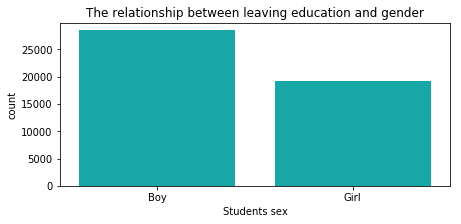

Boy     28455
Girl    19179
Name: Label_Sex, dtype: int64

In [0]:
f, ax = plot.subplots(figsize=(7, 3))
chart = sns.countplot(x="Label_Sex", data=students_tarke_tahsil, color="c");
chart.set(xlabel='Students sex', title = 'The relationship between leaving education and gender')
plt.show()

students_tarke_tahsil['Label_Sex'].value_counts()

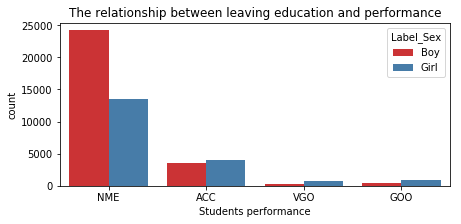

NME    37734
ACC     7547
GOO     1396
VGO      957
Name: Label_AverageLabel, dtype: int64

In [0]:
f, ax = plot.subplots(figsize=(7, 3))
chart = sns.countplot(x="Label_AverageLabel", data=students_tarke_tahsil, color="r", hue='Label_Sex', palette="Set1");
chart.set(xlabel='Students performance', title = 'The relationship between leaving education and performance')
plt.show()

students_tarke_tahsil['Label_AverageLabel'].value_counts()

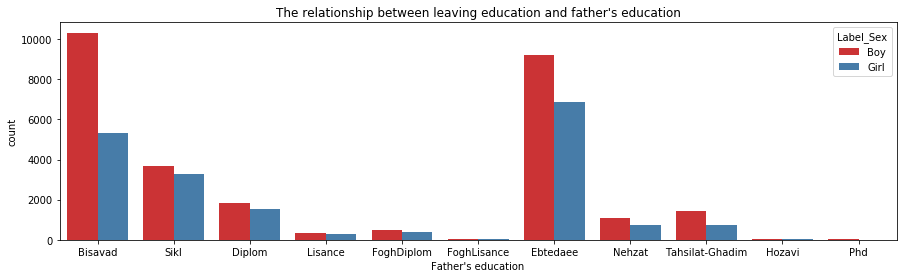

Ebtedaee           16056
Bisavad            15616
Sikl                6918
Diplom              3397
Tahsilat-Ghadim     2195
Nehzat              1793
FoghDiplom           863
Lisance              650
FoghLisance           79
Hozavi                42
Phd                   25
Name: Label_FatherMadrak, dtype: int64

In [0]:
f, ax = plot.subplots(figsize=(15, 4))
chart = sns.countplot(x="Label_FatherMadrak", data=students_tarke_tahsil, color="r", hue='Label_Sex', palette="Set1");
chart.set(xlabel="Father's education", title = "The relationship between leaving education and father's education")
plt.show()

students_tarke_tahsil['Label_FatherMadrak'].value_counts()

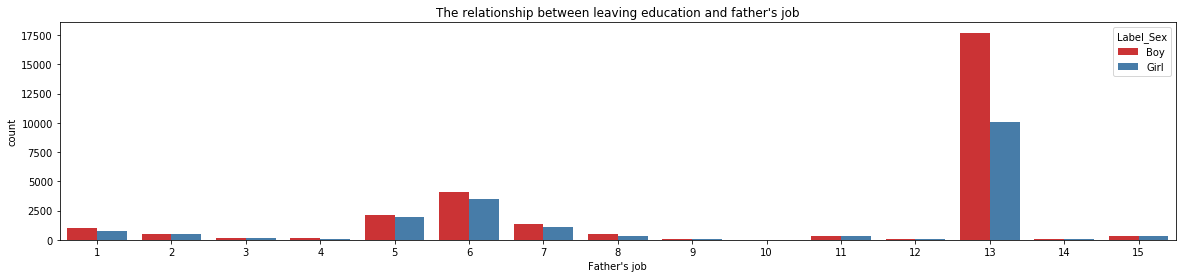

,FatherJob,Label_FatherJob,IsStudying
12,13,بيکار,27742
5,6,آزاد تجاري,7618
4,5,ساير کارمندان دولت,4099
6,7,آزاد صنعتي,2461
0,1,فرهنگي,1764
1,2,نظامي و انتظامي,966
7,8,کشاورزي يا دامداري,791
10,11,کارگر ساده,687
14,15,ساير,587
2,3,بهداشتي و درماني,334


In [0]:
f, ax = plot.subplots(figsize=(20, 4))
chart = sns.countplot(x="FatherJob", data=students_tarke_tahsil, color="r", hue='Label_Sex', palette="Set1");
chart.set(xlabel="Father's job", title = "The relationship between leaving education and father's job")
plt.show()

students_tarke_tahsil[['Label_FatherJob','FatherJob','IsStudying']].groupby(['FatherJob','Label_FatherJob'], as_index=False).count().sort_values(by = 'IsStudying',ascending = False)

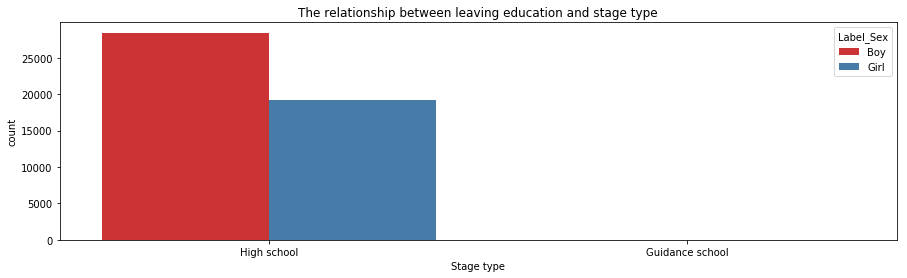

High school        47578
Guidance school       56
Name: Label_StageType, dtype: int64

In [0]:
f, ax = plot.subplots(figsize=(15, 4))
chart = sns.countplot(x="Label_StageType", data=students_tarke_tahsil, color="r", hue='Label_Sex', palette="Set1");
chart.set(xlabel='Stage type', title = "The relationship between leaving education and stage type")
plt.show()

students_tarke_tahsil['Label_StageType'].value_counts()

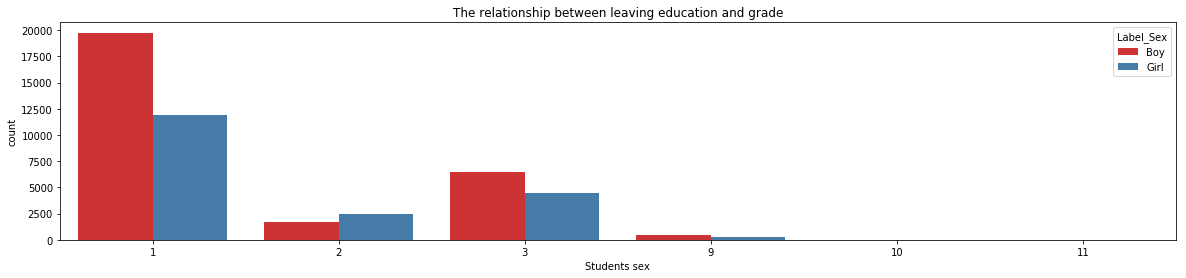

1     31714
3     10936
2      4203
9       769
10       11
11        1
Name: grade, dtype: int64

In [0]:
f, ax = plot.subplots(figsize=(20, 4))
chart = sns.countplot(x="grade", data=students_tarke_tahsil, color="r", hue='Label_Sex', palette="Set1");
chart.set(xlabel='grade', title = "The relationship between leaving education and grade")
plt.show()

students_tarke_tahsil['grade'].value_counts()

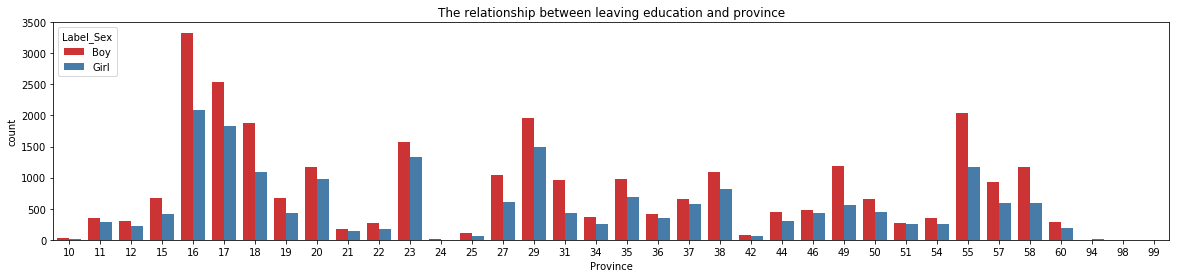

,OstanCode,OstanName,IsStudying
4,16,خراسان رضوی,5424
5,17,اصفهان,4375
15,29,آذربايجان غربي,3442
29,55,همدان,3219
6,18,آذربايجان شرقي,2968
11,23,فارس,2905
8,20,مازندران,2145
21,38,کرمان,1907
31,58,کردستان,1757
25,49,سيستان و بلوچستان,1751


In [0]:
f, ax = plot.subplots(figsize=(20, 4))
chart = sns.countplot(x="OstanCode", data=students_tarke_tahsil, color="r", hue='Label_Sex', palette="Set1");
chart.set(xlabel='Province', title = "The relationship between leaving education and province")
plt.show()

students_tarke_tahsil[['OstanName','OstanCode','IsStudying']].groupby(['OstanCode','OstanName'], as_index=False).count().sort_values(by = 'IsStudying',ascending = False)
